In [1]:
# Importing necessary libraries for data cleaning and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file_path = 'QF632_Project_1.csv'
df = pd.read_csv(file_path)

In [3]:
# Examine the structure and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1038 non-null   object 
 1   Signal     1038 non-null   float64
 2   Open       1038 non-null   float64
 3   High       1038 non-null   float64
 4   Low        1038 non-null   float64
 5   Close      1038 non-null   float64
 6   Adj Close  1038 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.9+ KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   132.132496   132.912495   130.542503   131.824993   
50%      17.298240   146.769997 

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [6]:
# Ensure dates are in the right format and sequence
date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
print(f"Invalid dates: {date_check}")

# Check for date sequence issues
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
date_order_issues = (df['Date'] != df['Date'].sort_values()).any()
if date_order_issues:
    print("Dates are out of order")
else:
    print("Dates are in correct order")


Invalid dates: 0
Dates are in correct order


In [7]:
# Ensure prices and signals are non-zero and positive
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
value_check = {col: (df[col] <= 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

Negative/zero values: {'Signal': 6, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 1}


In [8]:
# Correcting negative/zero historical prices and signal values using forward fill
for col in columns_to_check:
    # Replace zero and negative values with NaN
    df[col] = df[col].mask(df[col] <= 0)
    
    # Forward fill NaN values
    df[col].fillna(method='ffill', inplace=True)

In [9]:
# Verify changes made
value_check = {col: (df[col] <= 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

Negative/zero values: {'Signal': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0}


In [10]:
# Examine updated data structure and summary
print("Updated Data Summary:")
print(df.info())
print(df.describe())

Updated Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
                                Date       Signal         Open         High  \
count                           1038  1038.000000  1038.000000  1038.000000   
mean   2017-12-11 17:03:48.901734144    16.881893   141.847360   142.691801   
min              2015-11-19 00:00:00    10.582996    94.080002    95.400002   
25%              2016-11-30 06:00:00    14.842406   132.132496   132

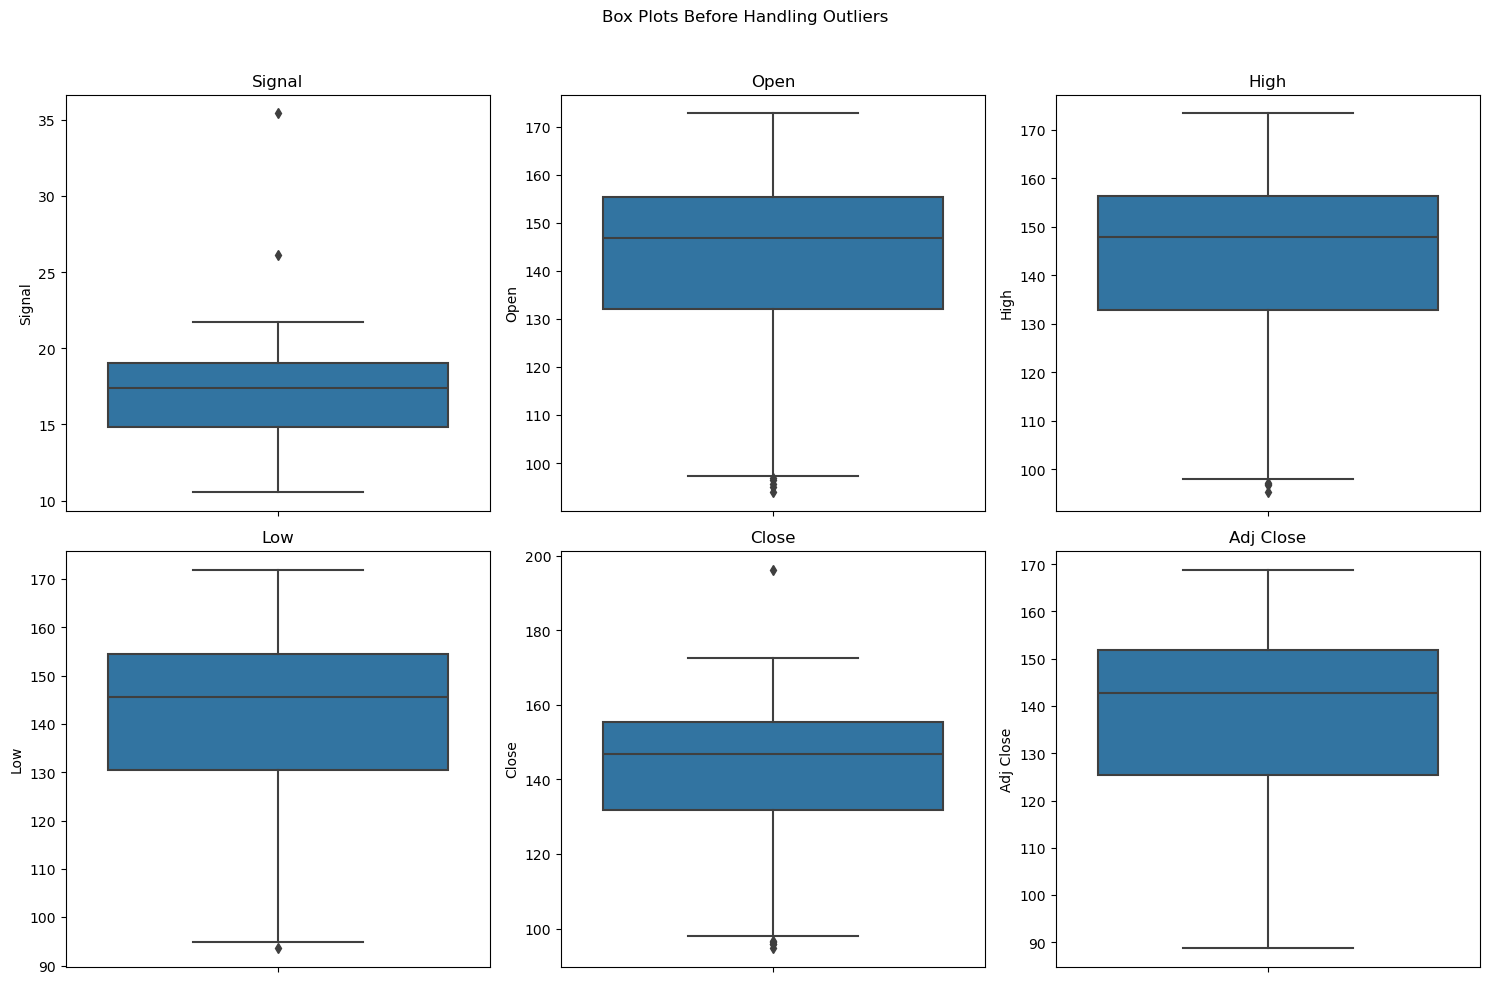

In [11]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
# Function to handle outliers using the z-score method
def handle_outliers_zscore(column):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = (df[column] - mean) / std
    outliers = abs(z_scores) > 3
    print(f"Outliers in {column}: {outliers.sum()}")
    
    # Replace outliers with NaN
    df.loc[outliers, column] = float('nan')
    
    # Forward fill NaN values
    df[column].fillna(method='ffill', inplace=True)

# Apply the z-score method to handle outliers in the specified columns
for col in columns_to_check:
    handle_outliers_zscore(col)

Outliers in Signal: 2
Outliers in Open: 0
Outliers in High: 0
Outliers in Low: 0
Outliers in Close: 0
Outliers in Adj Close: 0


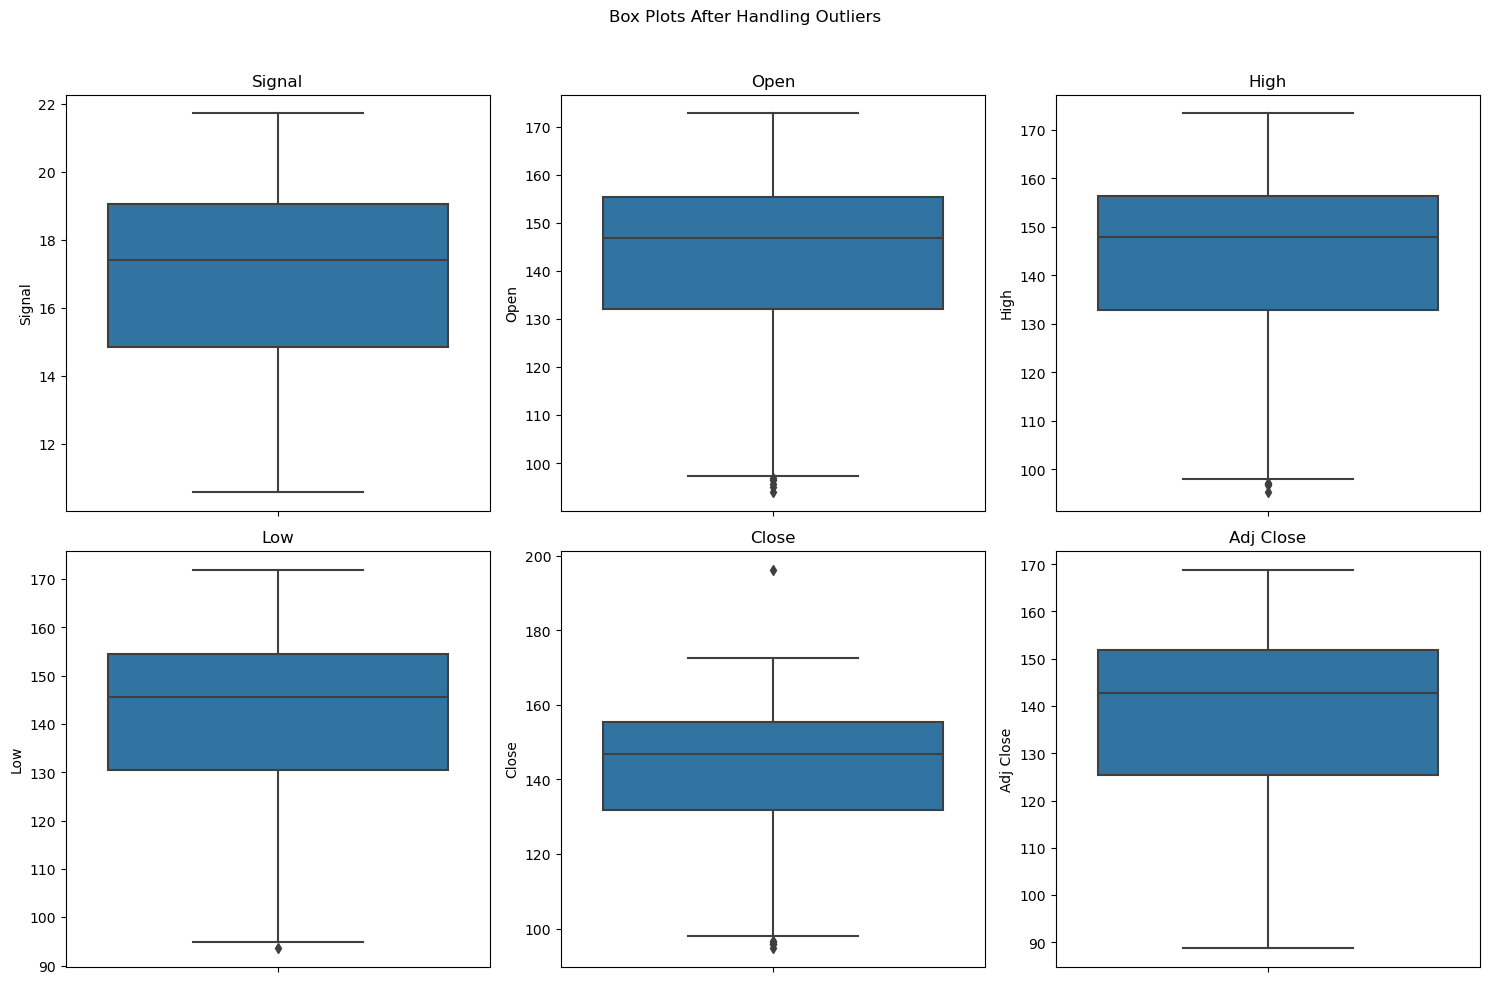

In [13]:
# Plot box plots after handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots After Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

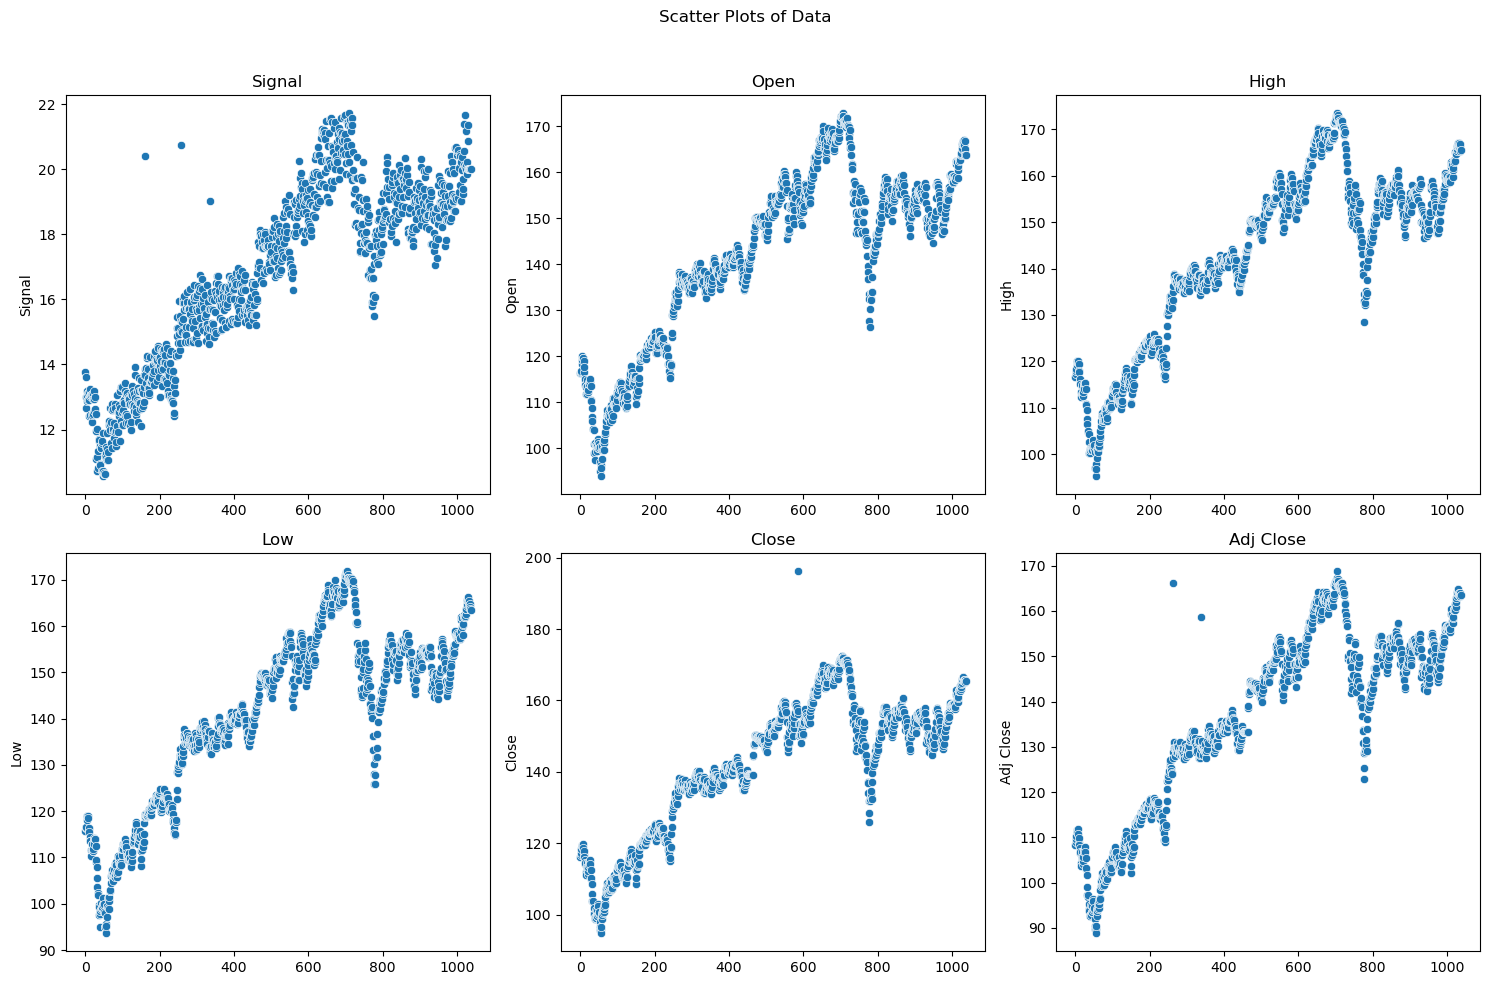

In [14]:
# Plot scatter plots
plt.figure(figsize=(15, 10))
plt.suptitle('Scatter Plots of Data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df.index, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Number of data points with increases more than 10 times the average move in Signal: 1
Number of data points with increases more than 10 times the average move in Open: 0
Number of data points with increases more than 10 times the average move in High: 0
Number of data points with increases more than 10 times the average move in Low: 0
Number of data points with increases more than 10 times the average move in Close: 1
Number of data points with increases more than 10 times the average move in Adj Close: 2


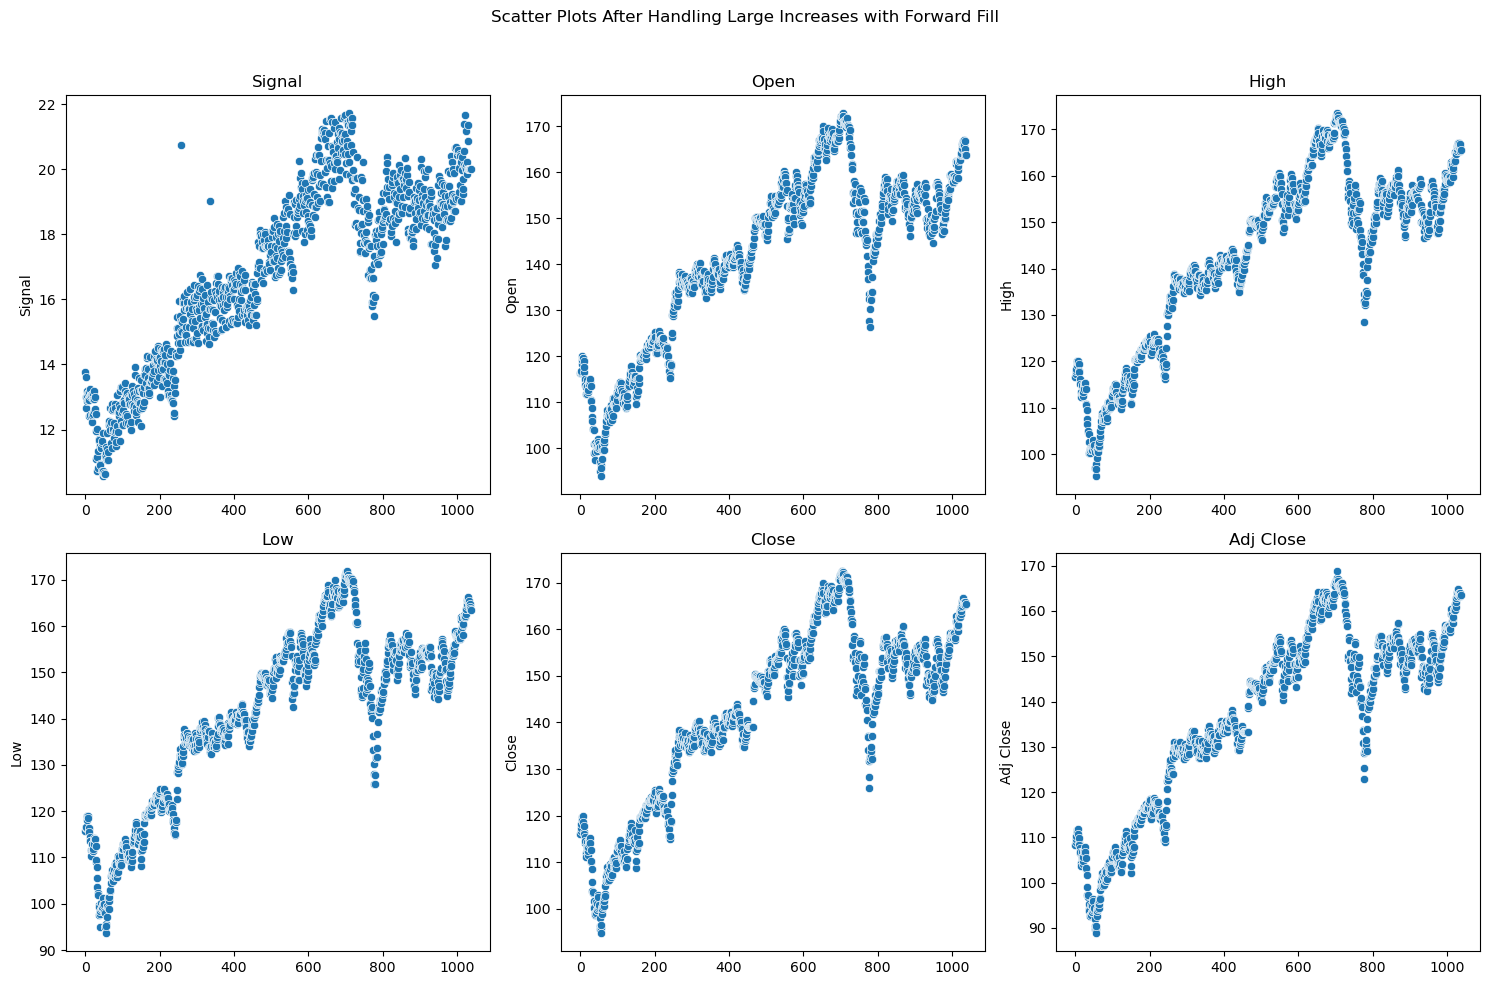

In [15]:
# Function to handle large increases by forward filling
def handle_large_increases_ffill(column, multiplier):
    # Calculate the differences between consecutive data points
    differences = df[column].diff()
    
    # Identify data points with increases more than 10 times the average move
    large_increases = differences > (multiplier * differences.abs().mean())
    
    # Replace data points with large increases with NaN
    df.loc[large_increases, column] = float('nan')
    
    # Forward fill NaN values
    df[column].fillna(method='ffill', inplace=True)
    
    print(f"Number of data points with increases more than {multiplier} times the average move in {column}: {large_increases.sum()}")

# Specify the multiplier for identifying large increases
multiplier = 10  # Adjust this multiplier as needed

# Handle large increases by forward filling for each column
for col in columns_to_check:
    handle_large_increases_ffill(col, multiplier)

# Plot scatter plots after handling large increases
plt.figure(figsize=(15, 10))
plt.suptitle('Scatter Plots After Handling Large Increases with Forward Fill')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df.index, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [16]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
                                Date       Signal         Open         High  \
count                           1038  1038.000000  1038.000000  1038.000000   
mean   2017-12-11 17:03:48.901734144    16.852883   141.847360   142.691801   
min              2015-11-19 00:00:00    10.582996    94.080002    95.400002   
25%              2016-11-30 06:00:00    14.821290   132.132496   132.912495   
50%        

Other interesting exploratory data analysis

Moving average volatility 20 day window

In [17]:
# Calculate daily returns for given column
def calculate_daily_returns(df, column):
    df[f'{column} Daily Return'] = df[column].pct_change()
    return df.dropna()

# Calculate rolling volatility for given column
def calculate_rolling_volatility(df, column, window=20):
    df[f'{column} Rolling Volatility'] = df[f'{column} Daily Return'].rolling(window=window).std() * np.sqrt(window)
    return df.dropna()

# Main function
def analyze_volatility(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate daily returns and rolling volatility for Adj Close
    df = calculate_daily_returns(df, 'Adj Close')
    df = calculate_rolling_volatility(df, 'Adj Close')
    
    # Calculate daily returns and rolling volatility for Signal
    df = calculate_daily_returns(df, 'Signal')
    df = calculate_rolling_volatility(df, 'Signal')
    
    return df

# Load and analyze data
df_volatility = analyze_volatility(df)

# Output the results
print("Data with Daily Returns and Rolling Volatility:")
df_volatility

Data with Daily Returns and Rolling Volatility:


,Date,Signal,Open,High,Low,Close,Adj Close,Adj Close Daily Return,Adj Close Rolling Volatility,Signal Daily Return,Signal Rolling Volatility
40,2016-01-20,11.479756,97.430000,100.330002,95.059998,99.180000,92.934502,0.004151,0.061426,0.049102,0.250234
41,2016-01-21,10.913312,99.330002,100.910004,98.379997,98.949997,92.718971,-0.002319,0.059995,-0.049343,0.250618
42,2016-01-22,11.435968,100.650002,101.610001,100.129997,101.370003,94.986595,0.024457,0.065740,0.047892,0.252877
43,2016-01-25,11.433675,100.739998,101.080002,98.849998,99.120003,92.878281,-0.022196,0.064994,-0.000201,0.252856
44,2016-01-26,11.577177,99.519997,101.400002,99.180000,101.099998,94.733612,0.019976,0.069925,0.012551,0.251964
...,...,...,...,...,...,...,...,...,...,...,...
1033,2019-12-30,20.016643,165.979996,166.210007,164.570007,165.440002,163.623688,-0.002532,0.022656,0.000000,0.207244
1034,2019-12-31,20.016643,165.080002,166.350006,164.710007,165.669998,163.851135,0.001390,0.019427,0.000000,0.206301
1035,2020-01-02,20.016643,166.740005,166.750000,164.229996,165.779999,163.959946,0.000664,0.018741,0.000000,0.197408
1036,2020-01-03,20.016643,163.740005,165.410004,163.699997,165.130005,163.317093,-0.003921,0.018930,0.000000,0.197336


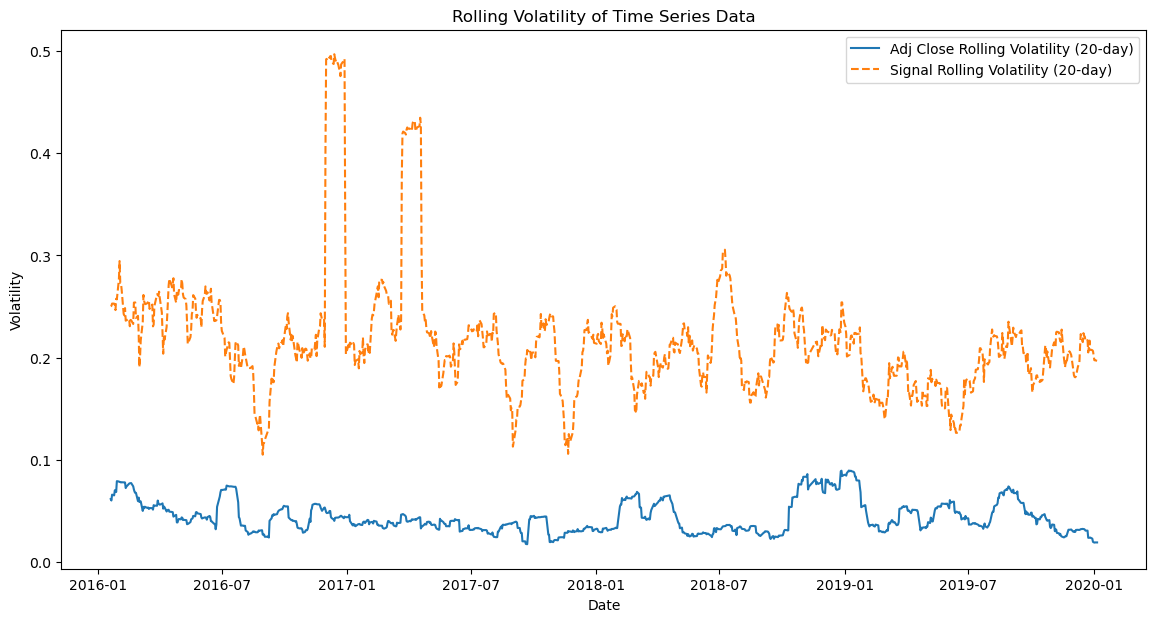

In [18]:
# Plotting the combined rolling volatility
plt.figure(figsize=(14, 7))
plt.plot(df_volatility['Date'], df_volatility['Adj Close Rolling Volatility'], label='Adj Close Rolling Volatility (20-day)')
plt.plot(df_volatility['Date'], df_volatility['Signal Rolling Volatility'], label='Signal Rolling Volatility (20-day)', linestyle='--')
plt.title('Rolling Volatility of Time Series Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [19]:
# Descriptive statistics
print("\nDescriptive Statistics for Adj Close Rolling Volatility:")
print(df_volatility['Adj Close Rolling Volatility'].describe())
print("\nDescriptive Statistics for Signal Rolling Volatility:")
print(df_volatility['Signal Rolling Volatility'].describe())


Descriptive Statistics for Adj Close Rolling Volatility:
count    998.000000
mean       0.043576
std        0.015603
min        0.017176
25%        0.031884
50%        0.039314
75%        0.052910
max        0.089412
Name: Adj Close Rolling Volatility, dtype: float64

Descriptive Statistics for Signal Rolling Volatility:
count    998.000000
mean       0.217084
std        0.059696
min        0.104887
25%        0.185500
50%        0.211211
75%        0.232045
max        0.497114
Name: Signal Rolling Volatility, dtype: float64


## Part 2

In [20]:
df_cross_corr = df.copy()
df_cross_corr['Date'] = pd.to_datetime(df_cross_corr['Date'])
df_cross_corr = df_cross_corr.set_index('Date').asfreq('D').dropna() 

# To define the range of lags
max_lag = 10
lag_range = np.arange(-max_lag, max_lag + 1)

# To compute the cross-correlation between Signal indicator and each price columns with a corresponding lag 
cross_corr_matrix = []
for columns in df_cross_corr.columns:
    if columns == 'Signal':
        continue    
    cross_corr = []
    for lag in lag_range:
        cross_corr.append(df_cross_corr['Signal'].corr(df_cross_corr[columns].shift(lag)))
    cross_corr_matrix.append(cross_corr)

# To determine the optimal lag that corresponds to the underlying price
for index, cross_corr in enumerate(cross_corr_matrix):
    optimal_lag_index = np.argmax(np.abs(cross_corr))
    optimal_lag = lag_range[optimal_lag_index]
    column_name = df_cross_corr.columns[index + 1]  # Skip the 'Signal' column
    if optimal_lag <= 0:
        print(f'{column_name} indicator is a \033[1mlagging indicator\033[0m ({optimal_lag} days) and is \033[1mineffective\033[0m in forecasting ETF')
    elif optimal_lag > 0:
        print(f'{column_name} indicator is a \033[1mleading indicator\033[0m ({optimal_lag} days) and is \033[1meffective\033[0m in forecasting ETF')

Open indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
High indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Low indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Close indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Adj Close indicator is a lagging indicator (-6 days) and is ineffective in forecasting ETF
Adj Close Daily Return indicator is a lagging indicator (-9 days) and is ineffective in forecasting ETF


Actual Open Price vs Predicted Open Price
Mean Squared Error: 23.77
Root Mean Squared Error: 4.87
Mean Absolute Error: 3.88
R-squared: 0.92


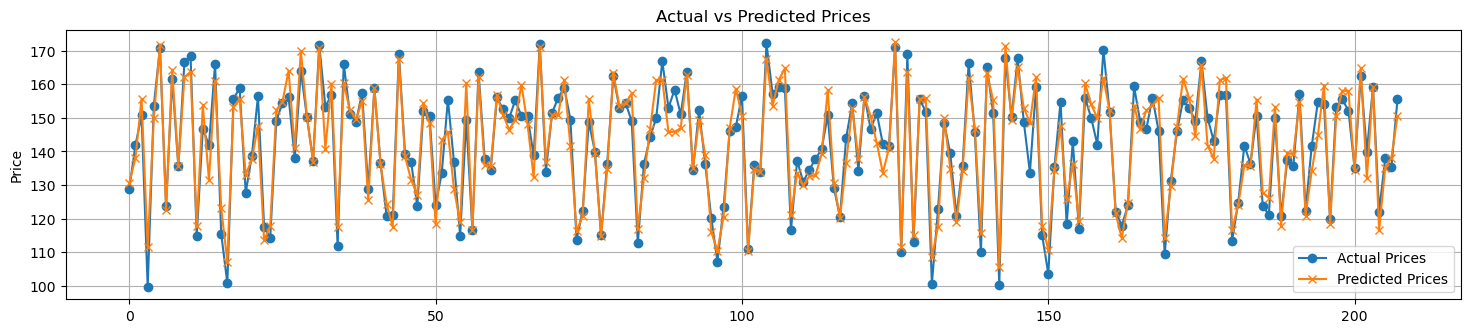

Actual High Price vs Predicted High Price
Mean Squared Error: 22.96
Root Mean Squared Error: 4.79
Mean Absolute Error: 3.82
R-squared: 0.92


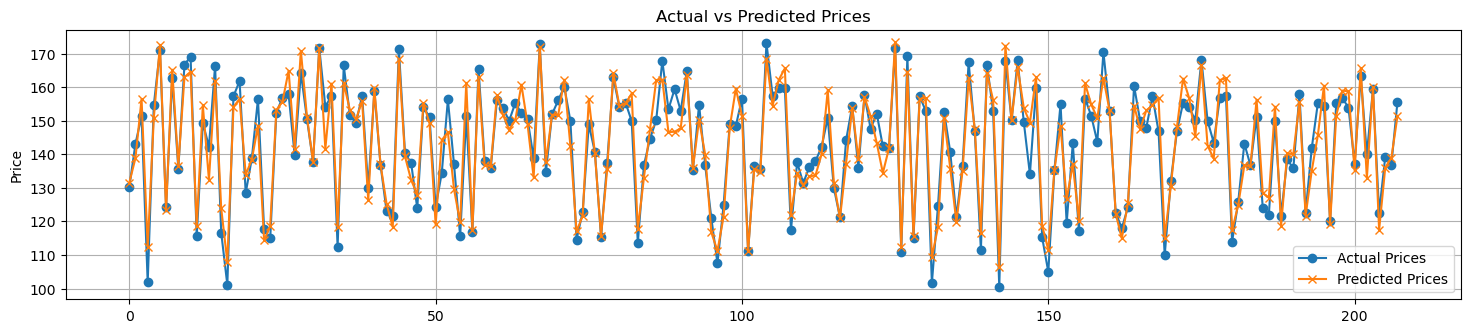

Actual Low Price vs Predicted Low Price
Mean Squared Error: 24.52
Root Mean Squared Error: 4.95
Mean Absolute Error: 3.93
R-squared: 0.92


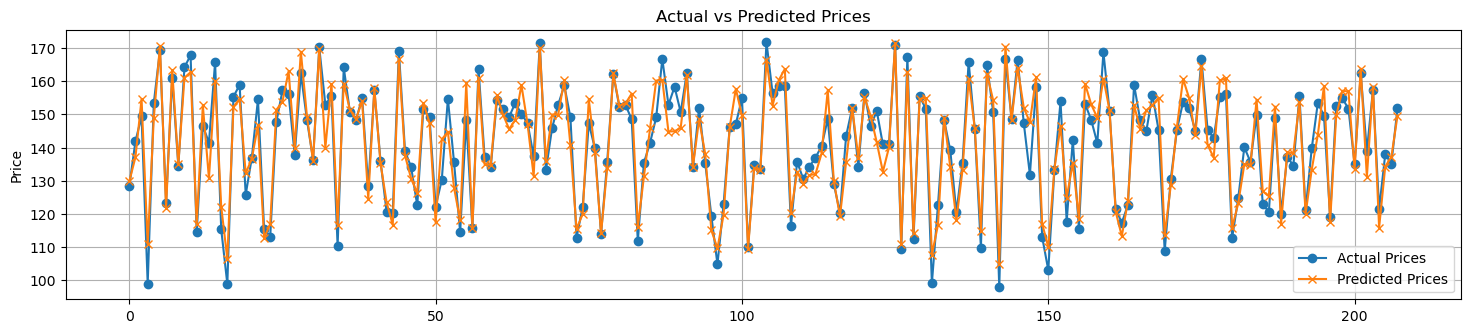

Actual Close Price vs Predicted Close Price
Mean Squared Error: 23.11
Root Mean Squared Error: 4.81
Mean Absolute Error: 3.82
R-squared: 0.92


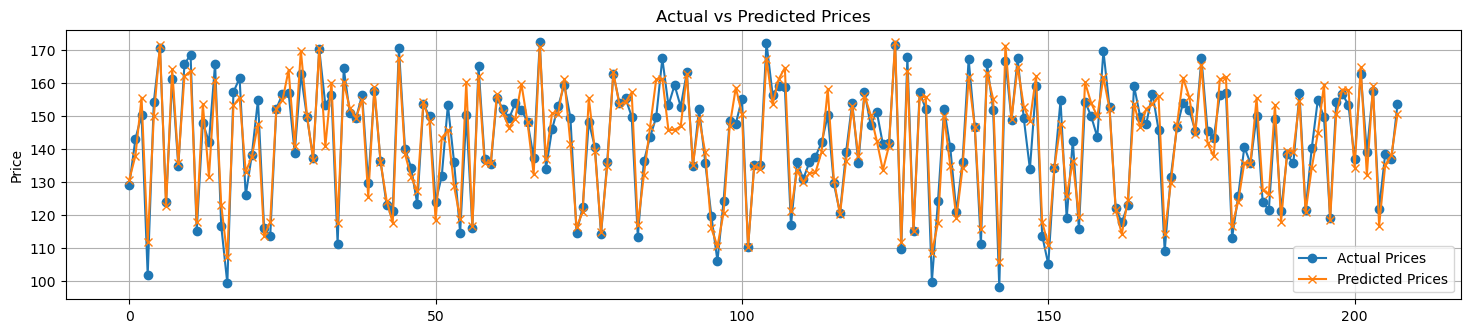

Actual Adj Close Price vs Predicted Adj Close Price
Mean Squared Error: 21.71
Root Mean Squared Error: 4.66
Mean Absolute Error: 3.76
R-squared: 0.94


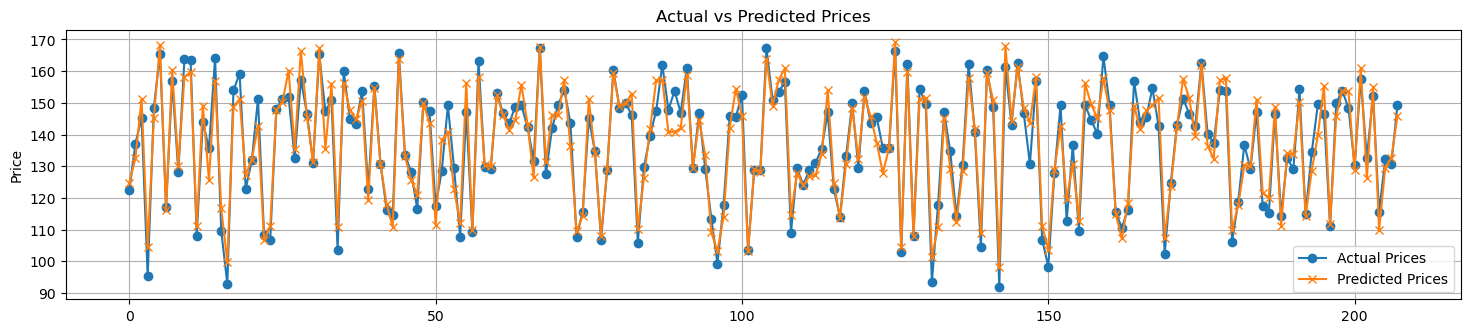

In [21]:
# Linear Regression Analysis, to determine whether the Signal Indicator is a able to predict/forecast clsoing prices

df_linear_reg = df.copy()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for each_column in df_linear_reg.columns[2:-1]:

    # To define target and feature for the linear regression model
    feature_data = df_linear_reg[['Signal']]
    target_data = df_linear_reg[each_column]

    # To create a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(feature_data, 
                                                        target_data, 
                                                        test_size = 0.2, 
                                                        random_state = 10)

    # To create the linear regression model to price
    model = LinearRegression()
    model.fit(X_train, y_train)

    # To predict the closing price
    y_pred = model.predict(X_test)

    # To determine the Signal's ability to predict the price
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R-squared: {r2:.2f}')

    # To visualise the performance of the model
    plt.figure(figsize = (18, 3.5))
    plt.plot(y_test.values, 
             label = 'Actual Prices', 
             marker = 'o')
    plt.plot(y_pred, 
             label = 'Predicted Prices', 
             marker = 'x')
    plt.title('Actual vs Predicted Prices')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Actual Open Price vs Predicted Open Price
                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2614.693
Date:                Sun, 02 Jun 2024   AIC                           5237.387
Time:                        16:52:48   BIC                           5256.268
Sample:                             0   HQIC                          5244.628
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8322      1.285     26.335      0.000      31.314      36.350
Signal         6.4093      0.075     85.978      0.000       6.263       6.555
ar.L1     

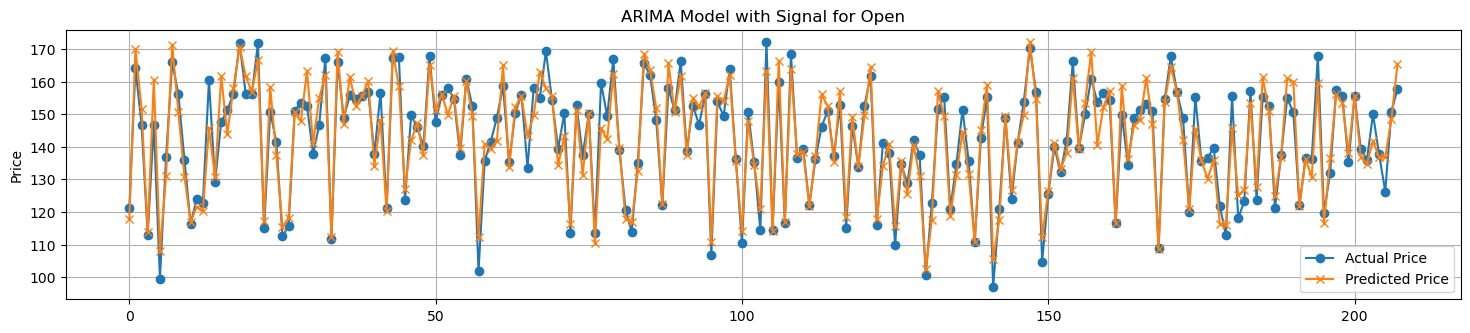

Actual High Price vs Predicted High Price
                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2596.893
Date:                Sun, 02 Jun 2024   AIC                           5201.786
Time:                        16:52:48   BIC                           5220.667
Sample:                             0   HQIC                          5209.027
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4709      1.267     27.212      0.000      31.988      36.954
Signal         6.4214      0.073     87.437      0.000       6.277       6.565
ar.L1     

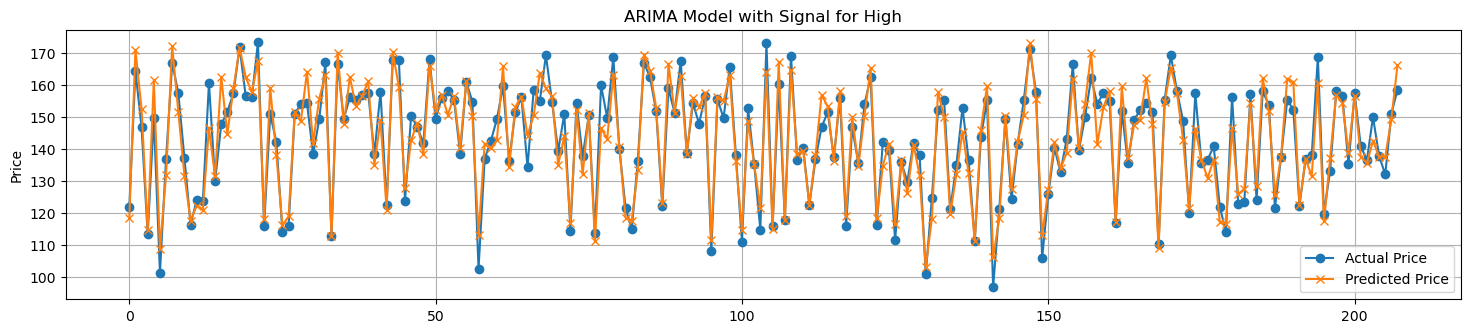

Actual Low Price vs Predicted Low Price
                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2616.984
Date:                Sun, 02 Jun 2024   AIC                           5241.968
Time:                        16:52:48   BIC                           5260.849
Sample:                             0   HQIC                          5249.209
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2689      1.286     25.871      0.000      30.748      35.789
Signal         6.3876      0.075     85.499      0.000       6.241       6.534
ar.L1       

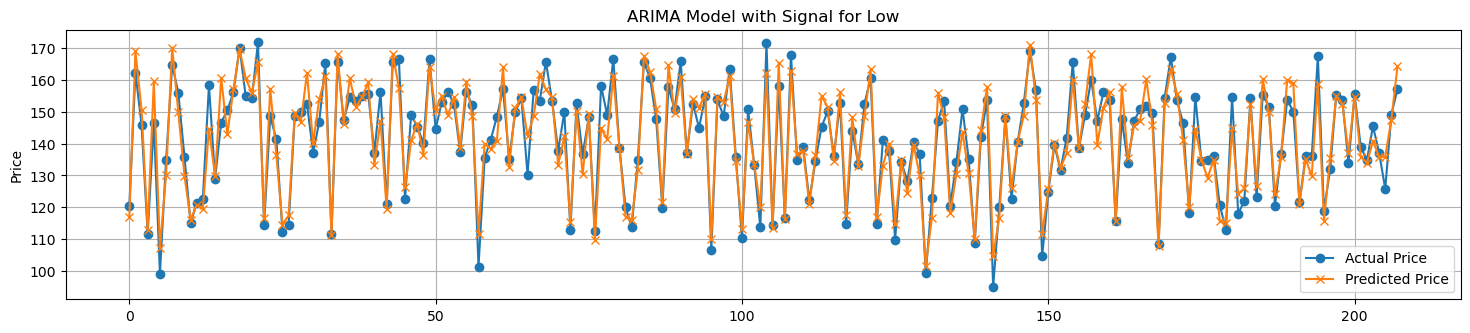

Actual Close Price vs Predicted Close Price
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2597.508
Date:                Sun, 02 Jun 2024   AIC                           5203.016
Time:                        16:52:48   BIC                           5221.897
Sample:                             0   HQIC                          5210.257
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.7283      1.260     26.766      0.000      31.259      36.198
Signal         6.4129      0.073     87.872      0.000       6.270       6.556
ar.L1   

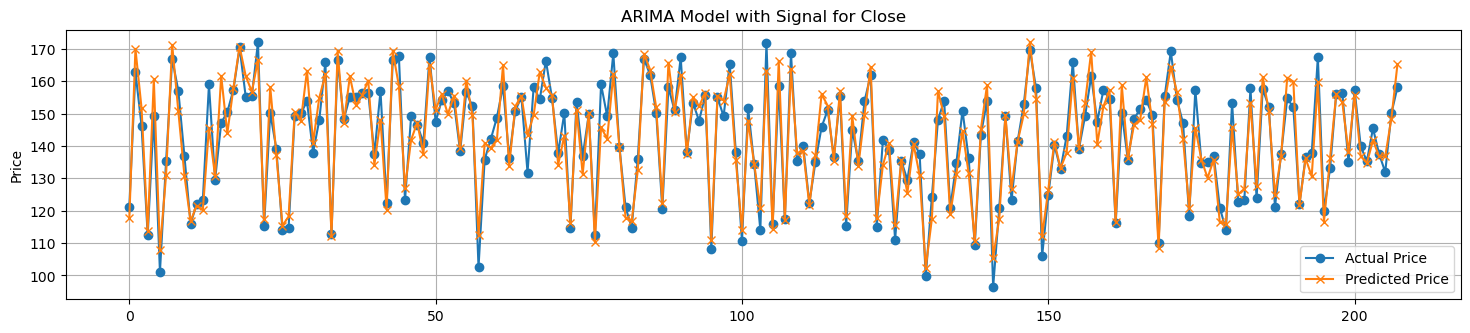

Actual Adj Close Price vs Predicted Adj Close Price
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  829
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2577.355
Date:                Sun, 02 Jun 2024   AIC                           5162.710
Time:                        16:52:48   BIC                           5181.591
Sample:                             0   HQIC                          5169.951
                                - 829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9281      1.254     17.480      0.000      19.469      24.387
Signal         6.8020      0.072     94.122      0.000       6.660       6.944


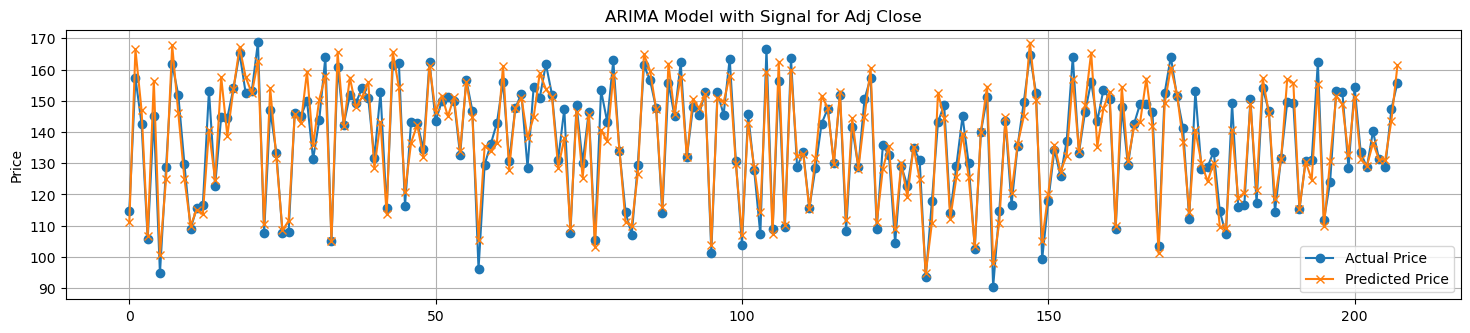

In [22]:
# ARIMA Model, to determine whether the Signal Indicator is a able to predict/forecast clsoing prices

df_arima = df.copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima = df_arima.set_index('Date').asfreq('D').dropna() 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

for each_column in df_arima.columns[1 : -1]:

    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    
    feature_data = df_arima[['Signal']]
    target_data = df_arima[each_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_data, 
                                                        target_data, 
                                                        test_size=0.2,
                                                        random_state = 10)
    
    # Fit ARIMA model 
    model = ARIMA(y_train, X_train, order=(1, 0, 0))
    arima_fit = model.fit()
    print(arima_fit.summary())
    
    # Predict future prices using the signal
    signal_forecast = arima_fit.forecast(steps = len(X_test), exog = X_test)

    # To determine the Signal's ability to predict the price
    arima_mse = mean_squared_error(y_test, signal_forecast)
    arima_rmse = np.sqrt(arima_mse)
    arima_mae = mean_absolute_error(y_test, signal_forecast)
    arima_r2 = r2_score(y_test, signal_forecast)


    print(f'Mean Squared Error: {arima_mse:.2f}')
    print(f'Root Mean Squared Error: {arima_rmse:.2f}')
    print(f'Mean Absolute Error: {arima_mae:.2f}')
    print(f'R-squared: {arima_r2:.2f}')

    # Plot the actual vs. predicted values
    plt.figure(figsize = (18, 3.5))
    plt.plot(range(len(y_test)), 
             y_test, 
             label = 'Actual Price',
             marker = 'o')
    plt.plot(range(len(y_test)), 
             signal_forecast, 
             label = 'Predicted Price',
             marker = 'x')
    plt.title(f'ARIMA Model with Signal for {each_column}')
    plt.ylabel('Price')
    plt.legend()    
    plt.grid(True)
    plt.show()

Actual Open Price vs Predicted Open Price
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 0.0048
Test Loss: 0.0047877077013254166
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Actual Open Price vs Predicted Open Price
Mean Squared Error: 29.66
Root Mean Squared Error: 5.45
Mean Absolute Error: 4.25
R-squared: 0.91


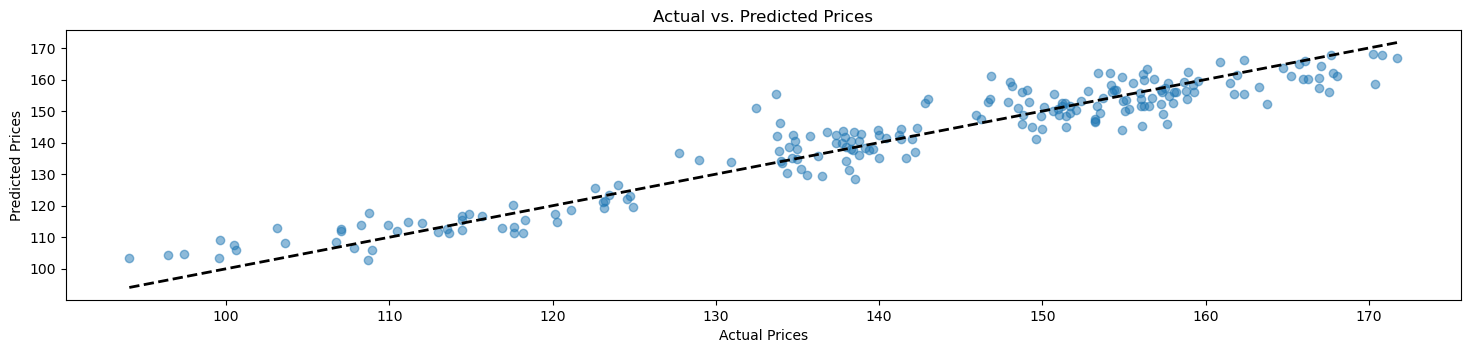

Actual High Price vs Predicted High Price


In [ ]:
df_nn = df.copy()
df_nn['Date'] = pd.to_datetime(df_nn['Date'])
df_nn = df_nn.set_index('Date').asfreq('D').dropna()

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

# Iterate over each column (except 'Date')
for each_column in df_nn.columns[1 : -1]:
    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')

    # Extract feature and target data
    feature_data = df_nn['Signal'].values.reshape(-1, 1) 
    target_data = df_nn[each_column].values.reshape(-1, 1) 

    # To normalize the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(feature_data)
    y_scaled = scaler_y.fit_transform(target_data)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                        test_size = 0.2, random_state = 42)

    # To define the neural network architecture
    model = Sequential([
        Dense(64, activation = 'relu', input_shape = (1, )),
        Dense(64, activation = 'relu'),
        Dense(1)
    ])

    # To compile the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # To train the model
    history = model.fit(X_train, y_train, epochs = 500, batch_size = 32, 
                        validation_split = 0.2, verbose = 0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print('Test Loss:', loss)

    # Predicting the price
    predictions = model.predict(X_test)
    predictions_inv = scaler_y.inverse_transform(predictions)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # To determine the Signal's ability to predict the price
    nn_mse = mean_squared_error(y_test_inv, predictions_inv)
    nn_rmse = np.sqrt(nn_mse)
    nn_mae = mean_absolute_error(y_test_inv, predictions_inv)
    nn_r2 = r2_score(y_test_inv, predictions_inv)

    print(f'\033[1mActual {each_column} Price vs Predicted {each_column} Price\033[0m')
    print(f'Mean Squared Error: {nn_mse:.2f}')
    print(f'Root Mean Squared Error: {nn_rmse:.2f}')
    print(f'Mean Absolute Error: {nn_mae:.2f}')
    print(f'R-squared: {nn_r2:.2f}')

    # Plot actual vs. predicted prices
    plt.figure(figsize=(18, 3.5))
    plt.scatter(y_test_inv, predictions_inv, alpha = 0.5)
    plt.plot([y_test_inv.min(), y_test_inv.max()], 
             [y_test_inv.min(), y_test_inv.max()], 
             'k--', lw = 2)
    plt.title('Actual vs. Predicted Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.show()